**Problem Statement:** There is a huge number of digital archival images of one of the influencial persons in the history of the world, Mahatma Gandhi. We want to process those images with computer vision and machine learning tools to identify the people in those images. Although classically it is an easy task. But as Havlicek V. et al. suggested in their paper (https://arxiv.org/abs/1804.11326) that we may get computational speedup if we can use efficient and effective quantum algorithm. So, our main goal of this project is to build an efficient multiclass quantum classifier to process images.

**Project plan:** At first, we have chosen a publicly available dataset to run our algorithm and have found CIFAR-10 dataset is one of the suitable ones to run our experiments. The deatils of the dataset is given in the link: https://www.cs.toronto.edu/~kriz/cifar.html. From our theoretical understanding we have found that we can only perform binary classification within the hilbert space unless it is not an ensemble or any other state-of-the-art approach. So, we can only classify 2 classes at a time. Therefore, to build a multiclass classifier, we have taken 2 classes multiple times. In our project, we have three different team who have worked on 3 different platforms. Qiskit team has 3 members. IBM qiskit simulator has two different approachs. One approach is pretty straignt forward. We encode our data to the qubits, use parameterized circuit, measurement and cost function to train our quantum circuit and then with the optimized parameter from the optimizer, we performe our test on the test dataset. Another approach is given in the link: (https://github.com/Qiskit/qiskit-machine-learning/blob/stable/0.2/docs/tutorials/05_torch_connector.ipynb). In this approach, a Qiskit's TorchConnector class is introduced. TorchConnector allows a natural integration of any NeuralNetwork from Qiskit Machine Learning into a PyTorch workflow.TorchConnector takes a Qiskit NeuralNetwork and makes it available as a PyTorch Module. The resulting module can be seamlessly incorporated into PyTorch classical architectures and trained jointly without additional considerations, enabling the development and testing of novel hybrid quantum-classical machine learning architectures.We have performed our experiments on the data with both of the approachs. 



**QISKIT Platform (Approach 2):** In this approach, we has embedded a (Quantum) NeuralNetwork into a target PyTorch workflow to classify CIFAR-10 dataset in a hybrid quantum-classical manner.

**Inspiration:** https://qiskit.org/textbook/ch-machine-learning/machine-learning-qiskit-pytorch.html


**Setting up our environment:** To perform our classification task, first we need to install qiskit, pylatexenc and qiskit_machine_learning.

In [1]:
!pip install qiskit
!pip install pylatexenc

In [3]:
!pip install qiskit_machine_learning

**Importing Required Libraries:** We have to import all the reuired libraries and functions first to download, manipulate, train-test and optimize the quantum system to reach the desired outcome.

In [2]:
from torch import cat, no_grad
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (Module, Conv2d, Linear, Dropout2d, NLLLoss,
                     MaxPool2d, Flatten, Sequential, ReLU)
import torch.nn.functional as F

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from qiskit  import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

**Data Accumulation and Defining Dataloader:** We take advantage of the torchvision API to directly load CIFAR10 dataset and define torch DataLoaders for train and test. We have downloaded our data and assigned it to X_train and X_test. We also performed *Grayscale* transformation and image resizing to adjust our image to do further processing. Then, we define our classes. We checked the data size, shape and labels. After that, as promised earlier, we took two of the ten classes from the data to do classification. In this experiement, we have chosen first two classes, Airplane and Automobile.

In [6]:
batch_size = 1
import torchvision as tv
import torch.utils.data as data

trainTransform  = tv.transforms.Compose([tv.transforms.Grayscale(num_output_channels=1),transforms.Resize(size=(28, 28)),
                                    tv.transforms.ToTensor(), 
                                    transforms.Normalize(mean=[0.5], std=[0.5])])
X_train        = tv.datasets.CIFAR10(root='./data', train=True, download=True, transform=trainTransform)

Files already downloaded and verified


**Assigning Classes:**

In [7]:
classes=['airplane','automobile','bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

**Data Pattern Recognition:**

In [8]:
len(X_train)

50000

In [9]:
X_train[0]

(tensor([[[-0.6000, -0.6941, -0.6392, -0.4980, -0.3176, -0.1686, -0.1137,
           -0.0745, -0.0980, -0.2078, -0.1686, -0.1216, -0.1529, -0.2000,
           -0.1608, -0.1922, -0.1922, -0.1137, -0.1451, -0.1608, -0.1373,
           -0.0510,  0.0275,  0.0353,  0.0196,  0.0196, -0.0196, -0.0353],
          [-0.8667, -0.9529, -0.8039, -0.5922, -0.3647, -0.2471, -0.2706,
           -0.2863, -0.3412, -0.3882, -0.3961, -0.3569, -0.3490, -0.3333,
           -0.3098, -0.3647, -0.3412, -0.2471, -0.2549, -0.2314, -0.2706,
           -0.2863, -0.2314, -0.2078, -0.1843, -0.2392, -0.2863, -0.2941],
          [-0.8196, -0.8275, -0.6078, -0.4353, -0.3098, -0.2706, -0.3412,
           -0.3569, -0.3176, -0.3255, -0.3647, -0.2549, -0.2314, -0.2471,
           -0.2863, -0.3020, -0.2941, -0.2549, -0.2000, -0.1686, -0.2235,
           -0.2549, -0.2392, -0.2000, -0.1843, -0.2627, -0.2784, -0.3882],
          [-0.7569, -0.6784, -0.4353, -0.3569, -0.3490, -0.3412, -0.3882,
           -0.3725, -0.2627, -0.302

**Selecting 2 Classes from 10:**

In [10]:
idx= []
for i in range(int(0.1*len(X_train))):
  if X_train[i][1] in [0,1]:
        idx.append(X_train[i])

**Data Pattern Recognition for 2 Classes:**

In [11]:
len(idx)

965

**Defining Data Loader For 2 Classes:**

In [14]:
trainloader= data.DataLoader(idx, batch_size=batch_size, shuffle=True, num_workers=2)
images, labels  = iter(trainloader).next()
print (images.size())

torch.Size([1, 1, 28, 28])


**Data Visualization:** We also need to visualize our data to ensure whether we are on right track. Data Visualization also helps communicate our understanding of data in simple way. 

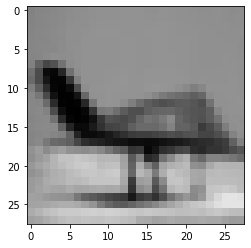

airplane


In [15]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

**Plotting Several Other Training Images:**

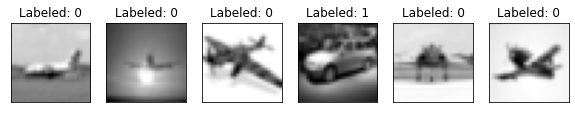

In [16]:
n_samples_show = 6 #six samples chosen

data_iter = iter(trainloader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets[0].item()))

    n_samples_show -= 1

**Defining Dataloader For Test Dataset:**

In [17]:
testTransform  = tv.transforms.Compose([tv.transforms.Grayscale(num_output_channels=1),transforms.Resize(size=(28, 28)),
                                    tv.transforms.ToTensor(), 
                                    transforms.Normalize(mean=[0.5], std=[0.5])])
X_test = datasets.CIFAR10(root='./data', train=False, download=True,
                        transform=testTransform)

idx_test= []
for i in range(int(0.05*len(X_train))):
  if X_test[i][1] in [0,1]:
        idx_test.append(X_test[i])

testloader= data.DataLoader(idx_test, batch_size=batch_size, shuffle=True, num_workers=2)
images, labels  = iter(testloader).next()
print (images.size())

Files already downloaded and verified
torch.Size([1, 1, 28, 28])


**Verifying Data Size and Data Pattern:**

In [18]:
print(len(X_test))

10000


In [19]:
len(idx_test)

493

**Defining the QNN and Hybrid Model:** This is where we can see the power of the TorchConnector. First, We created our quantum neural network layer(TwoLayerQNN). Then, we embed it into a layer in our torch Module by initializing a torch connector as TorchConnector(qnn).

In [5]:
qi = QuantumInstance(Aer.get_backend('statevector_simulator'))

In [20]:
feature_map = ZZFeatureMap(2)
ansatz = RealAmplitudes(2, reps=2)
qnn4 = TwoLayerQNN(2, feature_map, ansatz, input_gradients=True, exp_val=AerPauliExpectation(), quantum_instance=qi)
print(qnn4.operator)

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌──────────────────────────┐»
  q_0: ┤0                         ├»
       │  ZZFeatureMap(x[0],x[1]) │»
  q_1: ┤1                         ├»
       └──────────────────────────┘»
  «     ┌────────────────────────────────────────────────┐
  «q_0: ┤0                                               ├
  «     │  RealAmplitudes(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5]) │
  «q_1: ┤1                                               ├
  «     └────────────────────────────────────────────────┘
  )
])


In [21]:
class Net(Module):

    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2)         
        self.qnn = TorchConnector(qnn4)  
        self.fc3 = Linear(1, 1)          

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return cat((x, 1 - x), -1)

model4 = Net()

**Training Hybrid QNN Model:** In this section, we have trained our QNN. We have used ADAM optimizer for optimizaion. Learning rate is 0.001 and total number of epochs is 10. 

In [22]:
optimizer = optim.Adam(model4.parameters(), lr=0.001)
loss_func = NLLLoss()


epochs = 10     
loss_list = []  
model4.train()  
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(trainloader):
        optimizer.zero_grad(set_to_none=True)  
        output = model4(data)
        loss = loss_func(output, target)      
        loss.backward()                        
        optimizer.step()                       
        total_loss.append(loss.item())         
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training [10%]	Loss: -0.4831
Training [20%]	Loss: -0.7279
Training [30%]	Loss: -1.0307
Training [40%]	Loss: -1.4283
Training [50%]	Loss: -1.8704
Training [60%]	Loss: -2.2195
Training [70%]	Loss: -2.6295
Training [80%]	Loss: -3.1208
Training [90%]	Loss: -3.5538
Training [100%]	Loss: -4.1672


**Plotting Loss:** Now, we need to visualize how our loss function behaved in each training iteration. We have plotted that in the following section:

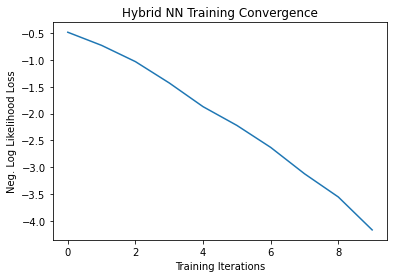

In [23]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg. Log Likelihood Loss')
plt.show()

**Testing Hybrid QNN Model:** After training our Hybrid QNN model, we need to check the performance of our model on unknown datasets. In this case, we have our prepared test data. We have applied out model and found Accuracy: 83.4%.

In [24]:
model4.eval() 
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(testloader):
        output = model4(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'
          .format(sum(total_loss) / len(total_loss),
                  correct / len(testloader) / batch_size * 100)
    )

Performance on test data:
	Loss: -4.2078
	Accuracy: 83.4%


**Visualizing Results:** After performing our testing, we need to ensure our result visually. So, we have plotted our test data with the prediction done by our machine.

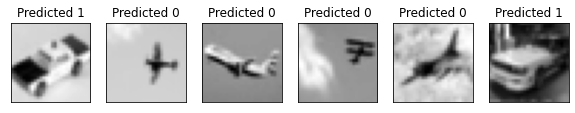

In [25]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model4.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(testloader):
        if count == n_samples_show:
            break
        output = model4(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))

        count += 1